In [51]:
# Standard libraries
import re
import csv
import nltk
import spacy
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

# Style
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
style.use('seaborn-poster')
from PIL import Image
from wordcloud import WordCloud

nlp = spacy.load('en_core_web_sm')

# Preprocessing
import en_core_web_sm
from collections import Counter
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet  
from sklearn.feature_extraction.text import CountVectorizer   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Building classification models
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

In [52]:
#Import data set
df_test = pd.read_csv('data/test_with_no_labels.csv')
df_train = pd.read_csv('data/train.csv')
#df_sample = pd.read_csv('data/sample_submission.csv')

In [53]:
print(df_test.shape)
print(df_train.shape)

display(df_test.head())
display(df_train.head())

percent_duplicates = round((1-(df_train['message'].nunique()/len(df_train['message'])))*100,2)
print('Duplicated tweets in train data:')
print(percent_duplicates,'%')

(10546, 2)
(15819, 3)


,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


Duplicated tweets in train data:
10.05 %


In [54]:
def modifyDf():
    df = df_train.copy()
    sentiment = df['sentiment']
    
    word_sentiment = []    
    for index in sentiment :
        if index == 1 :
            word_sentiment.append('Pro')
        elif index == 0 :
            word_sentiment.append('Neutral')
        elif index == -1 :
            word_sentiment.append('Anti')
        else :
            word_sentiment.append('News')
            
    df['sentiment'] = word_sentiment
    
    return df

df_train_copy = modifyDf()
df_train_copy.head()



,sentiment,message,tweetid
0,Pro,PolySciMajor EPA chief doesn't think carbon di...,625221
1,Pro,It's not like we lack evidence of anthropogeni...,126103
2,News,RT @RawStory: Researchers say we have three ye...,698562
3,Pro,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,Pro,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [55]:
def hashtag_extract(tweet):
    hashtags = []
       
    for i in tweet:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
        
    hashtags = sum(hashtags, [])
    frequency = nltk.FreqDist(hashtags)
    
    hashtag_df = pd.DataFrame({'hashtag': list(frequency.keys()),'count': list(frequency.values())})
    hashtag_df = hashtag_df.nlargest(15, columns="count")

    return hashtag_df

pro = hashtag_extract(df_train_copy['message'][df_train_copy['sentiment'] == 'Pro'])
anti = hashtag_extract(df_train_copy['message'][df_train_copy['sentiment'] == 'Anti'])
neutral = hashtag_extract(df_train_copy['message'][df_train_copy['sentiment'] == 'Neutral'])
news = hashtag_extract(df_train_copy['message'][df_train_copy['sentiment'] == 'News'])

pro.head()

,hashtag,count
19,climate,187
24,BeforeTheFlood,129
68,climatechange,94
13,ImVotingBecause,62
4,COP22,59


In [56]:
def CleanTweets(tweet):
    tweet = tweet.lower()
    tweet = re.sub('@[\w]*','',tweet)
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    tweet = re.sub(r'#\w*', '', tweet)    
    tweet = re.sub(r'\d+', '', tweet)  
    tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", ' ', tweet)
    tweet = re.sub(r"U+FFFD ", ' ', tweet)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    tweet = tweet.lstrip(' ')                        

    return tweet

df_train_copy['message'] = df_train_copy['message'].apply(CleanTweets)

df_train_copy.head()
    

,sentiment,message,tweetid
0,Pro,polyscimajor epa chief doesn t think carbon di...,625221
1,Pro,it s not like we lack evidence of anthropogeni...,126103
2,News,rt researchers say we have three years to act ...,698562
3,Pro,wired was a pivotal year in the war on climate...,573736
4,Pro,rt it s and a racist sexist climate change den...,466954


In [57]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV    
    else:
        return wordnet.NOUN

def lemma(df):
    df['length'] = df['message'].str.len()
    df['tokenized'] = df['message'].apply(word_tokenize)
    df['pos_tags'] = df['tokenized'].apply(nltk.tag.pos_tag)
        
    wnl = WordNetLemmatizer()
    df['pos_tags'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
    df['lemmatized'] = df['pos_tags'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
    df['lemmatized'] = [' '.join(map(str, l)) for l in df['lemmatized']]  
    return df

df_train_copy = lemma(df_train_copy)
df_train_copy.head()

,sentiment,message,tweetid,length,tokenized,pos_tags,lemmatized
0,Pro,polyscimajor epa chief doesn t think carbon di...,625221,102,"[polyscimajor, epa, chief, doesn, t, think, ca...","[(polyscimajor, a), (epa, n), (chief, n), (doe...",polyscimajor epa chief doesn t think carbon di...
1,Pro,it s not like we lack evidence of anthropogeni...,126103,62,"[it, s, not, like, we, lack, evidence, of, ant...","[(it, n), (s, v), (not, r), (like, n), (we, n)...",it s not like we lack evidence of anthropogeni...
2,News,rt researchers say we have three years to act ...,698562,86,"[rt, researchers, say, we, have, three, years,...","[(rt, n), (researchers, n), (say, v), (we, n),...",rt researcher say we have three year to act on...
3,Pro,wired was a pivotal year in the war on climate...,573736,54,"[wired, was, a, pivotal, year, in, the, war, o...","[(wired, v), (was, v), (a, n), (pivotal, a), (...",wire be a pivotal year in the war on climate c...
4,Pro,rt it s and a racist sexist climate change den...,466954,81,"[rt, it, s, and, a, racist, sexist, climate, c...","[(rt, v), (it, n), (s, n), (and, n), (a, n), (...",rt it s and a racist sexist climate change den...


In [68]:
def frequency(tweet):
    # Count vectorizer excluding english stopwords
    cv = CountVectorizer(stop_words='english')
    words = cv.fit_transform(tweet)
    
    # Count the words in the tweets and determine the frequency of each word
    sum_words = words.sum(axis=0)
    words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    # Create a dataframe to store the top 25 words and their frequencies
    frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
    frequency = frequency.head(25)
    
    return frequency

# Extract the top most 25 words in each class
pro_frequency = frequency(df_train_copy['lemmatized'][df_train_copy['sentiment']=='Pro'])
anti_frequency = frequency(df_train_copy['lemmatized'][df_train_copy['sentiment']=='Anti'])
news_frequency = frequency(df_train_copy['lemmatized'][df_train_copy['sentiment']=='News'])
neutral_frequency = frequency(df_train_copy['lemmatized'][df_train_copy['sentiment']=='Neutral'])

# Extract the words in the tweets for the pro and anti climate change classes 
anti_words = ' '.join([text for text in anti_frequency['word']])
pro_words = ' '.join([text for text in pro_frequency['word']])
news_words = ' '.join([text for text in news_frequency['word']])
neutral_words = ' '.join([text for text in neutral_frequency['word']])

# Create wordcloud for the anti climate change class
anti_wordcloud = WordCloud(width=800, 
                           height=500, 
                           random_state=110, 
                           max_font_size=110, 
                           background_color='white',
                           colormap="Reds").generate(anti_words)

# Create wordcolud for the pro climate change class
pro_wordcloud = WordCloud(width=800, 
                          height=500, 
                          random_state=73, 
                          max_font_size=110, 
                          background_color='white',
                          colormap="Greens").generate(pro_words)

# Create wordcolud for the news climate change class
news_wordcloud = WordCloud(width=800, 
                          height=500, 
                          random_state=0, 
                          max_font_size=110, 
                          background_color='white',
                          colormap="Blues").generate(news_words)

# Create wordcolud for the neutral climate change class
neutral_wordcloud = WordCloud(width=800, 
                          height=500, 
                          random_state=10, 
                          max_font_size=110, 
                          background_color='white',
                          colormap="Oranges").generate(neutral_words)

pro_frequency.tail()

,word,freq
20,http,359
21,make,322
22,like,318
23,warm,313
24,husband,312


C:\Users\erasto.malema\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


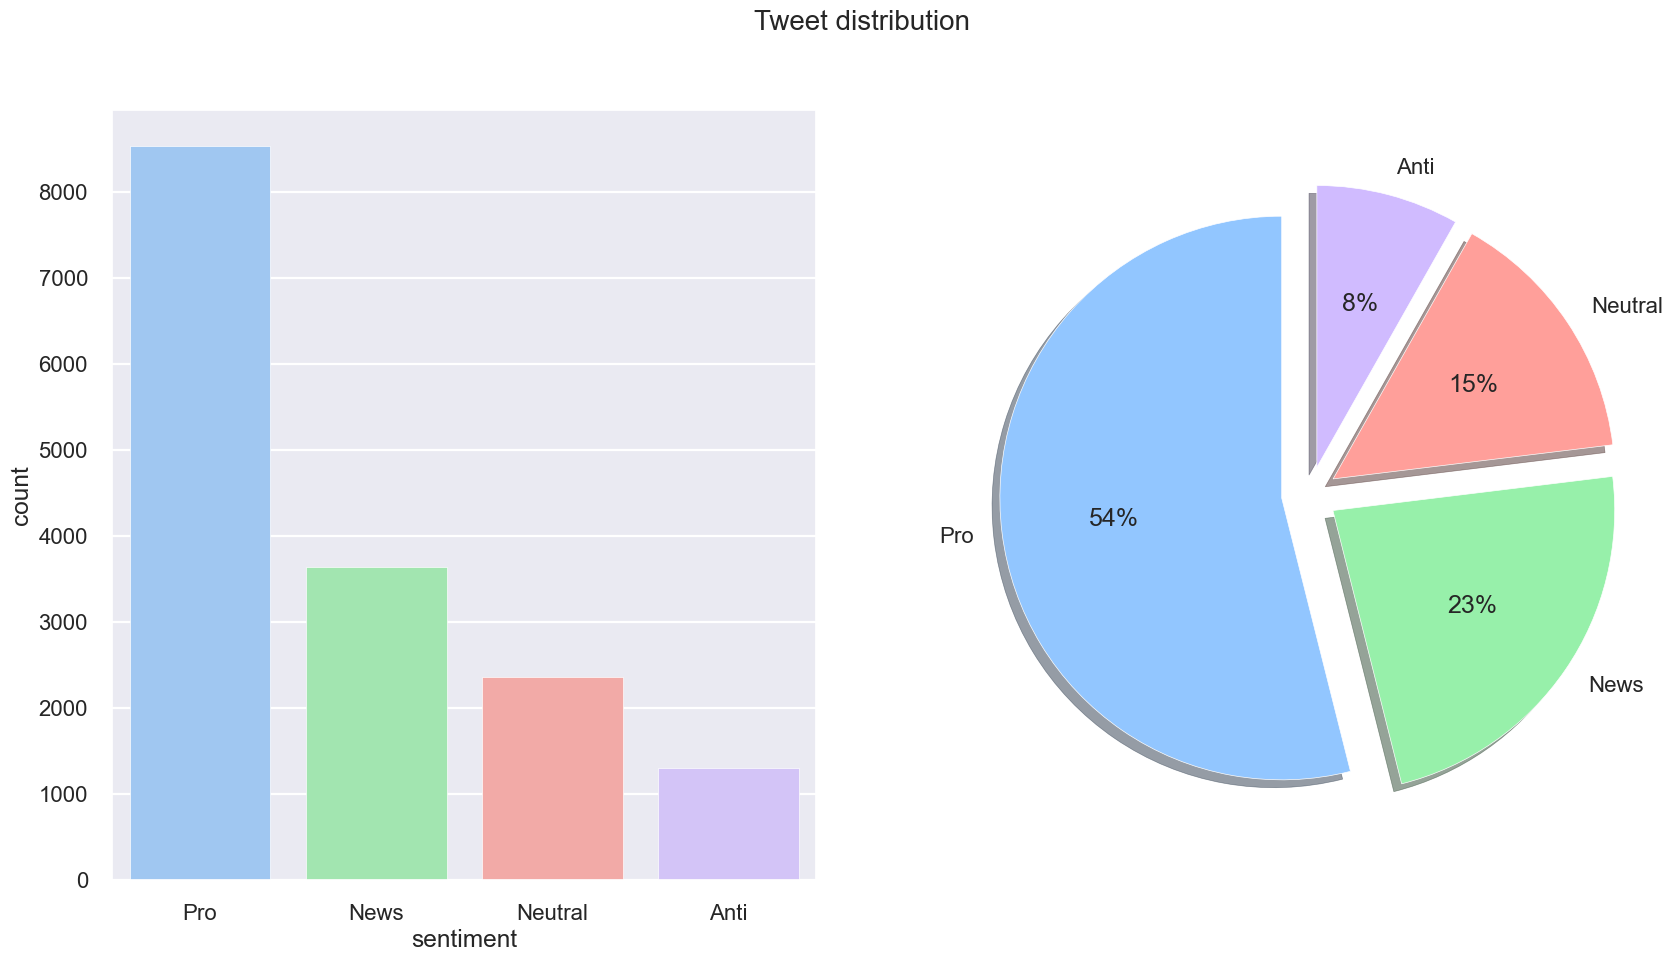

In [69]:
#EDSA: Target variable distribution

# Display target distribution
style.use('seaborn-pastel')

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 10), dpi=100)

sns.countplot(df_train_copy['sentiment'], ax=axes[0])

labels=['Pro', 'News', 'Neutral', 'Anti'] 

axes[1].pie(df_train_copy['sentiment'].value_counts(),
            labels=labels,
            autopct='%1.0f%%',
            shadow=True,
            startangle=90,
            explode = (0.1, 0.1, 0.1, 0.1))

fig.suptitle('Tweet distribution', fontsize=20)
plt.show()

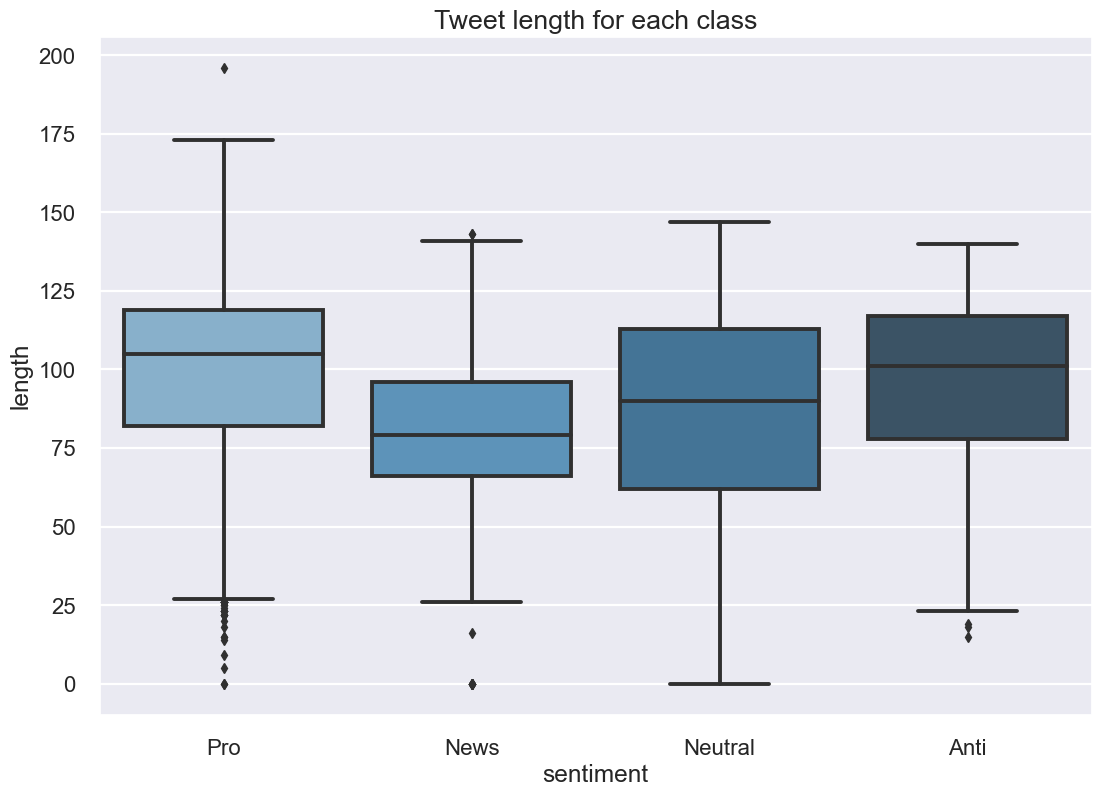

In [70]:
# Plot the distribution of the length tweets for each class using a box plot

sns.boxplot(x=df_train_copy['sentiment'], y=df_train_copy['length'], data=df_train_copy, palette=("Blues_d"))
plt.title('Tweet length for each class')
plt.show()

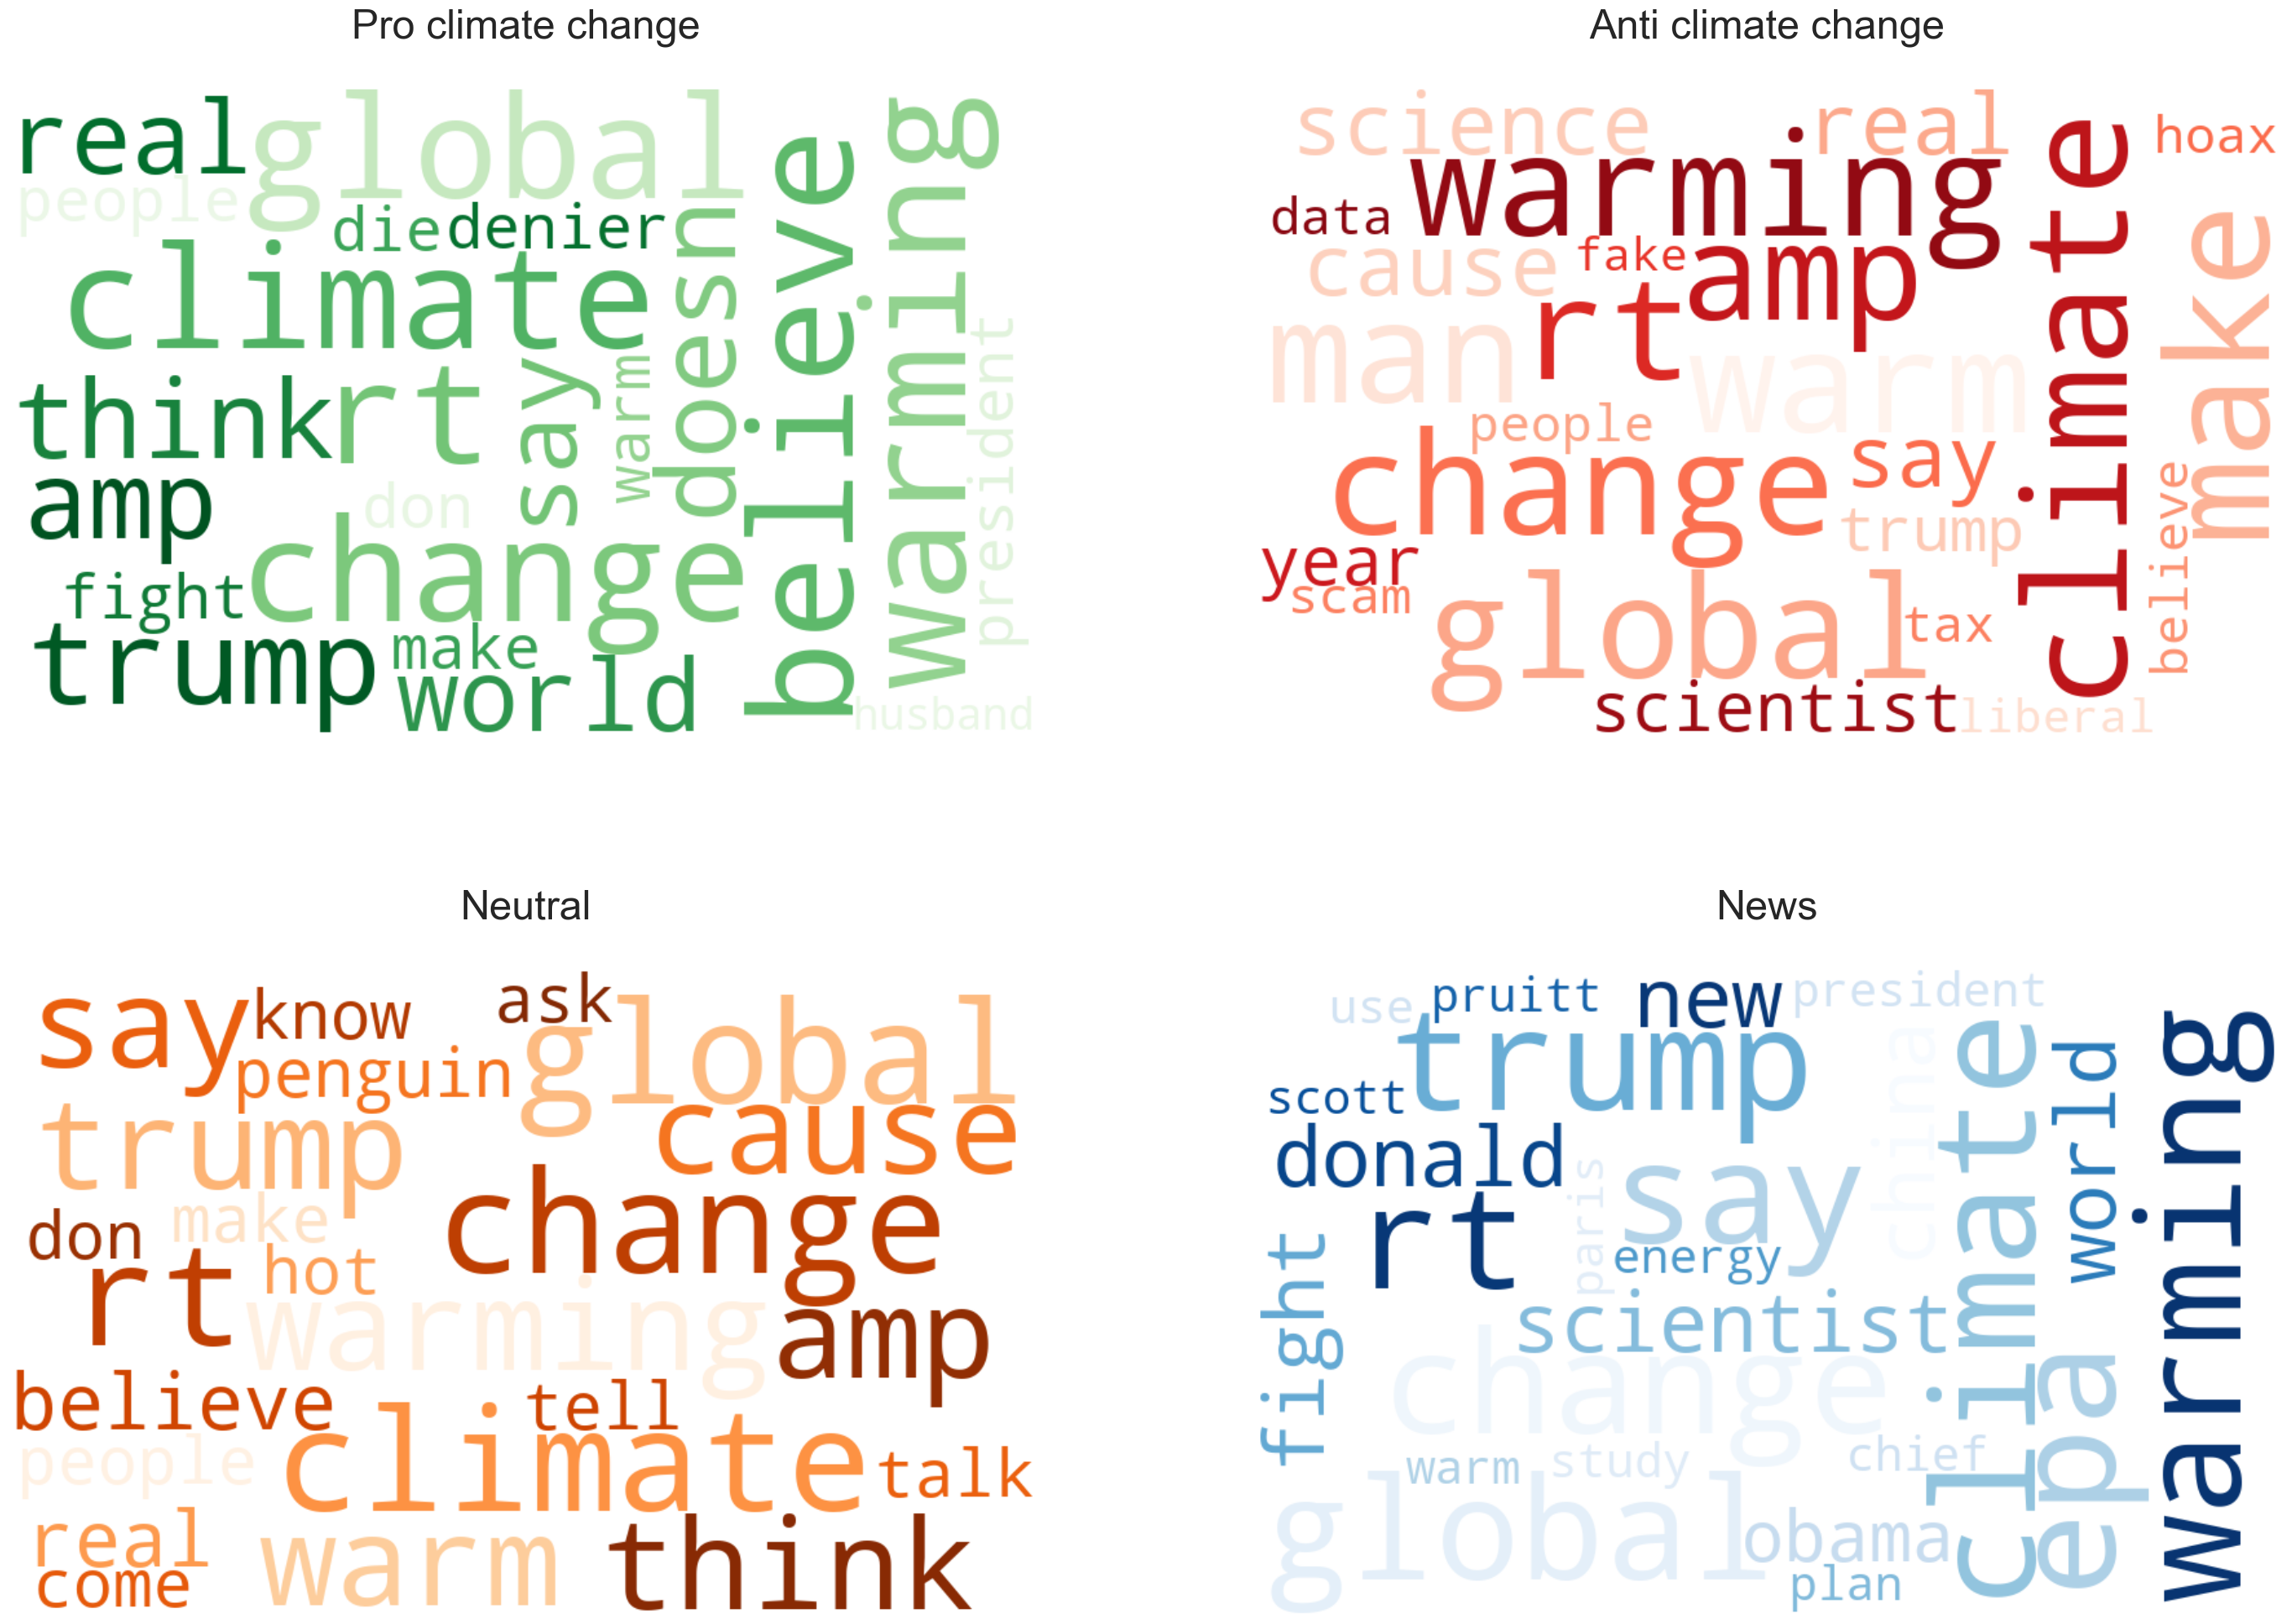

In [72]:
#EDSA: Climate change buzzwords

# Plot pro and anti wordclouds next to one another for comparisson
f, axarr = plt.subplots(2,2, figsize=(35,25))
axarr[0,0].imshow(pro_wordcloud, interpolation="bilinear")
axarr[0,1].imshow(anti_wordcloud, interpolation="bilinear")
axarr[1,0].imshow(neutral_wordcloud, interpolation="bilinear")
axarr[1,1].imshow(news_wordcloud, interpolation="bilinear")

# Remove the ticks on the x and y axes
for ax in f.axes:
    plt.sca(ax)
    plt.axis('off')

axarr[0,0].set_title('Pro climate change\n', fontsize=35)
axarr[0,1].set_title('Anti climate change\n', fontsize=35)
axarr[1,0].set_title('Neutral\n', fontsize=35)
axarr[1,1].set_title('News\n', fontsize=35)
#plt.tight_layout()
plt.show()


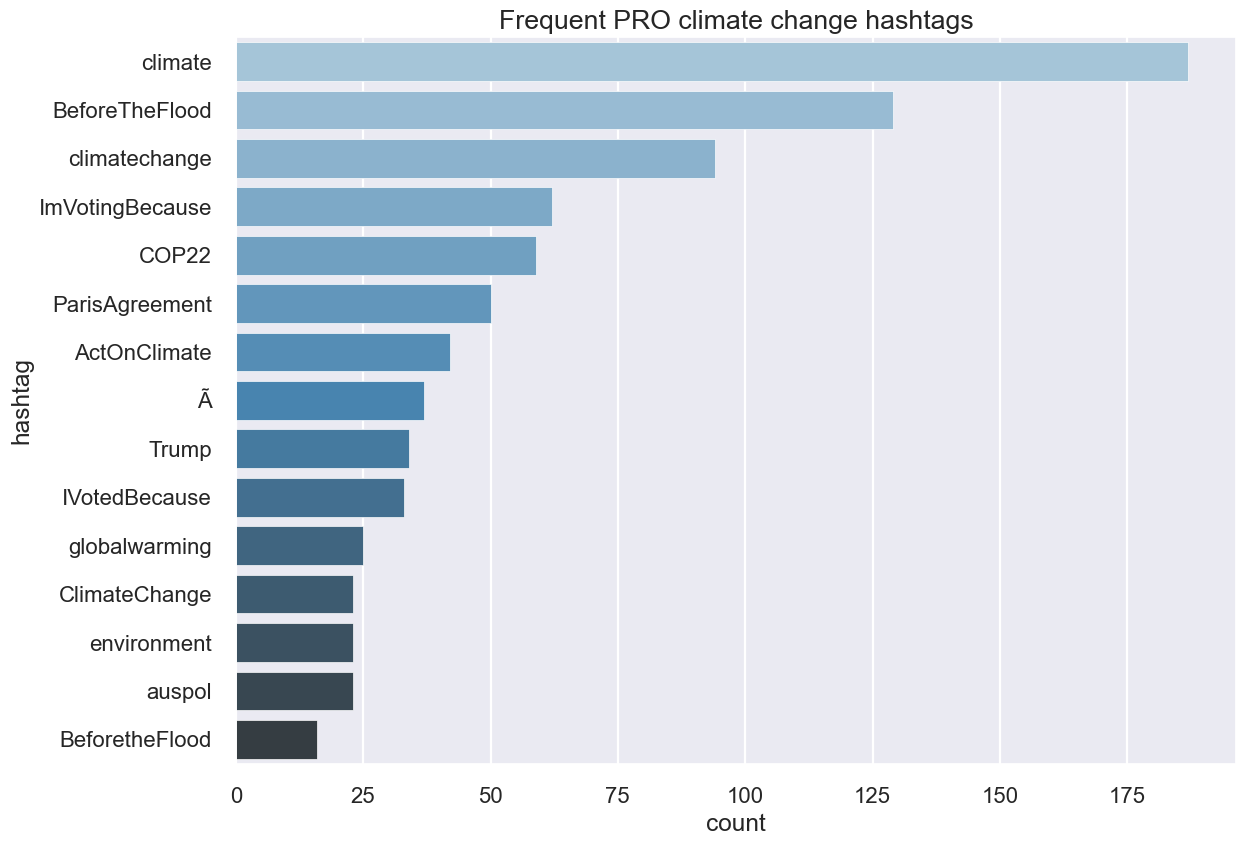

In [73]:
# Plot the frequent hastags for pro and anti climate change classes
sns.barplot(data=pro,y=pro['hashtag'], x=pro['count'], palette=("Blues_d"))
plt.title('Frequent PRO climate change hashtags')
plt.tight_layout()

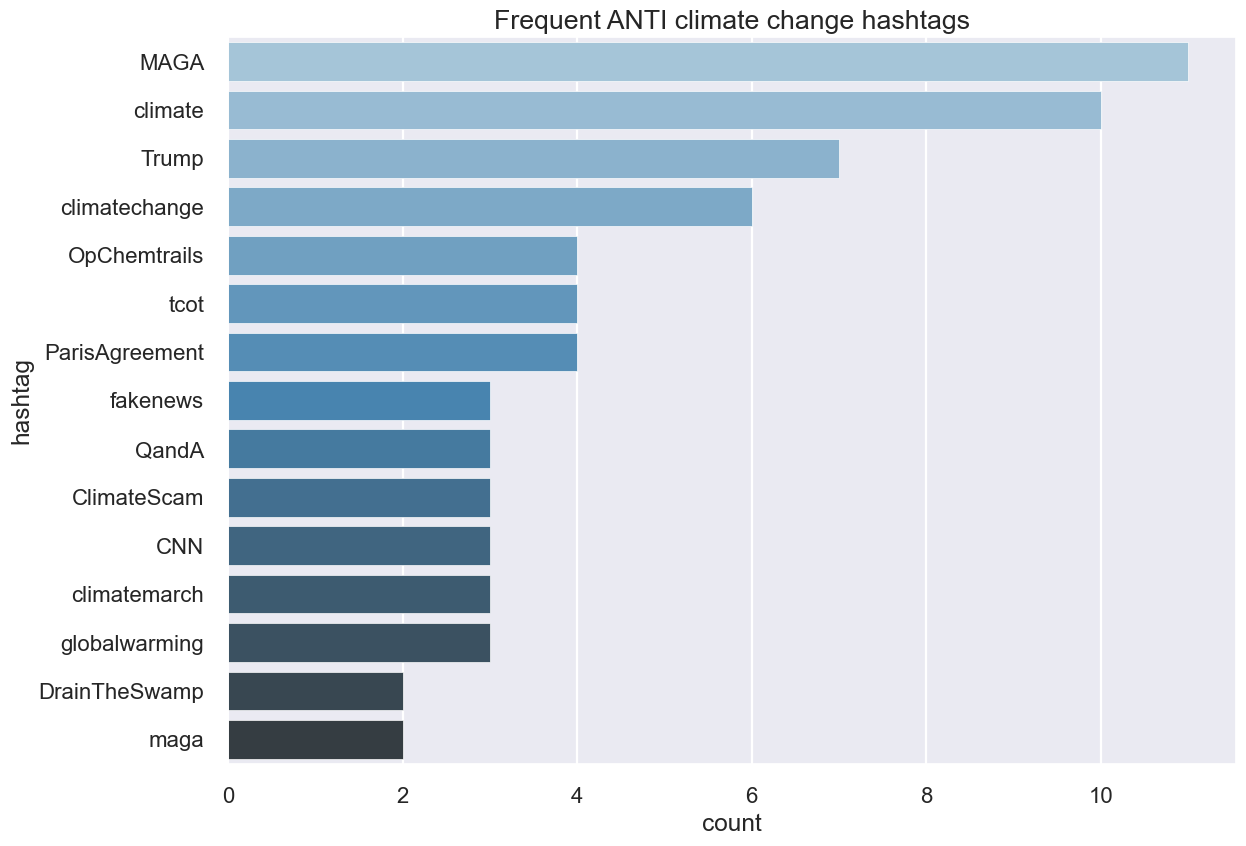

In [74]:
sns.barplot(data=anti,y=anti['hashtag'], x=anti['count'], palette=("Blues_d"))
plt.title('Frequent ANTI climate change hashtags')
plt.tight_layout()

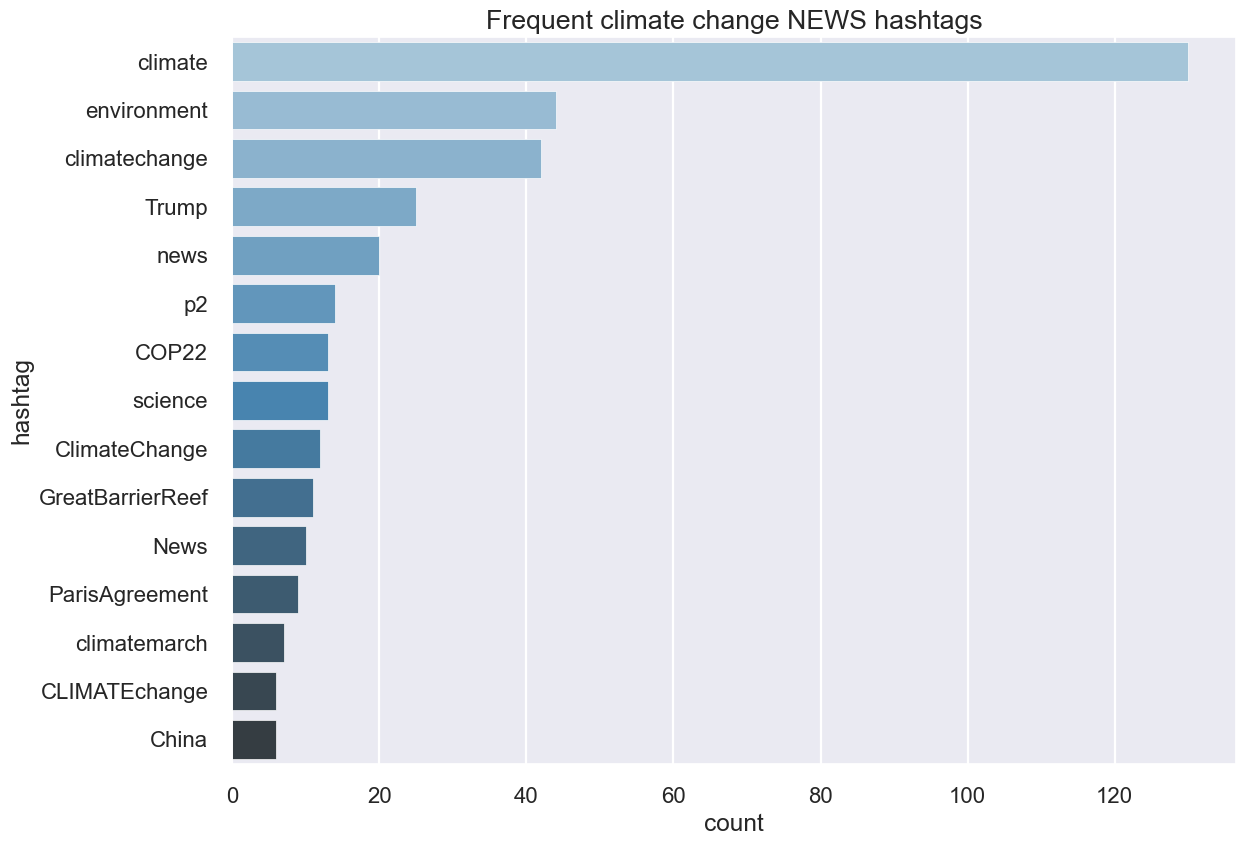

In [76]:
# Plot the frequent hastags for the news and neutral classes
sns.barplot(y=news['hashtag'], x=news['count'], palette=("Blues_d"))
plt.title('Frequent climate change NEWS hashtags')
plt.tight_layout()

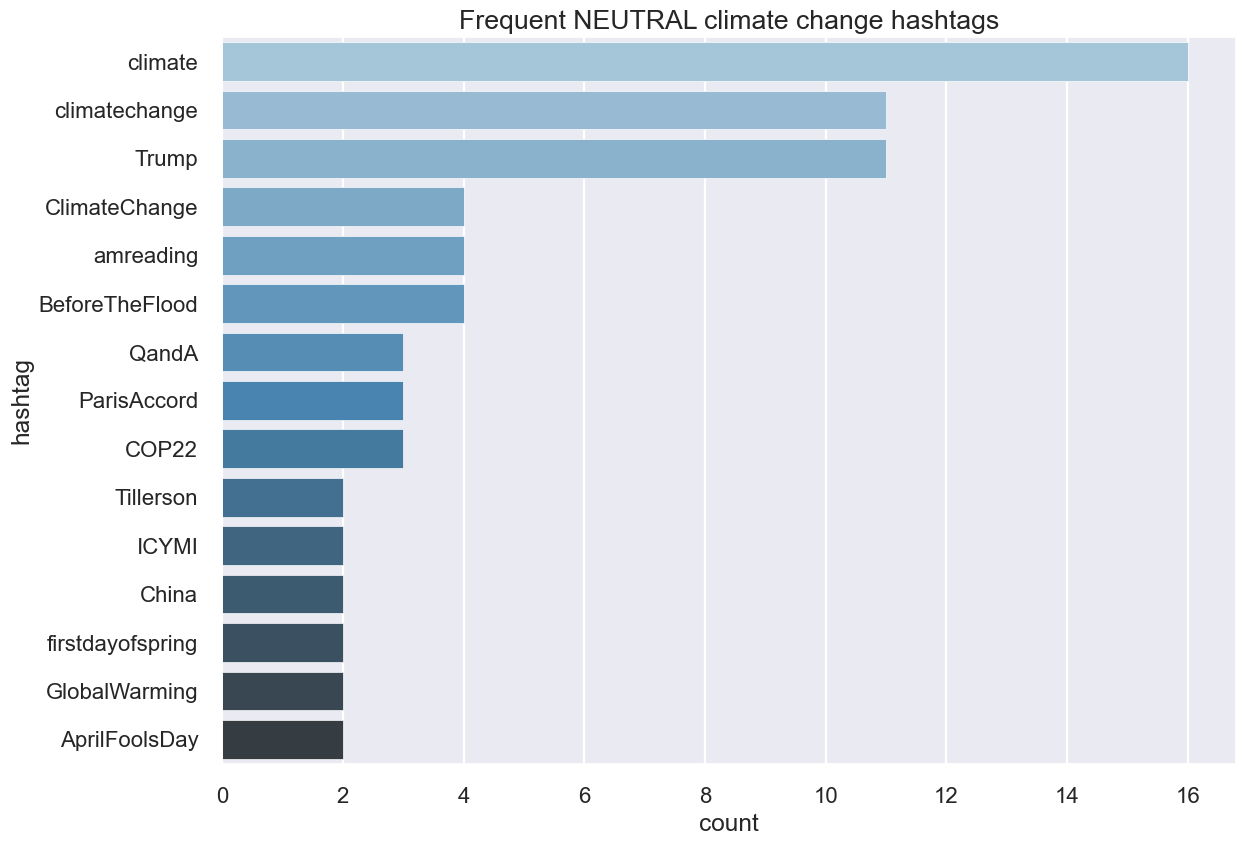

In [77]:
sns.barplot(y=neutral['hashtag'], x=neutral['count'], palette=("Blues_d"))
plt.title('Frequent NEUTRAL climate change hashtags')
plt.tight_layout()

In [67]:
#Building classification models
#Split the dataset into train & validation (25%) for model training

# Seperate features and tagret variables
X = df_train['message']
y = df_train['sentiment']

# Split the train data to create validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

In [41]:
# Random Forest Classifier
rf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(max_depth=5, n_estimators=100))])

# Train Random forest 
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)

# Generate a classification Report for the random forest model
print(metrics.classification_report(y_valid, y_pred_rf))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       336
           0       0.00      0.00      0.00       547
           1       0.55      1.00      0.71      2178
           2       0.00      0.00      0.00       894

    accuracy                           0.55      3955
   macro avg       0.14      0.25      0.18      3955
weighted avg       0.30      0.55      0.39      3955



C:\Users\erasto.malema\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erasto.malema\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erasto.malema\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
# Naïve Bayes:
nb = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

# Train Niave bayes
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_valid)

# Generate a classification Report for the Naive Bayes model
print(metrics.classification_report(y_valid, y_pred_nb))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       336
           0       1.00      0.05      0.09       547
           1       0.60      0.99      0.75      2178
           2       0.94      0.33      0.48       894

    accuracy                           0.63      3955
   macro avg       0.63      0.34      0.33      3955
weighted avg       0.68      0.63      0.53      3955



C:\Users\erasto.malema\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erasto.malema\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erasto.malema\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
# K-NN Classifier
knn = Pipeline([('tfidf', TfidfVectorizer()), ('clf', KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2))])

# Train K - nearest neighbors
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_valid)

print(metrics.classification_report(y_valid, y_pred_knn))

              precision    recall  f1-score   support

          -1       0.56      0.40      0.47       336
           0       0.48      0.39      0.43       547
           1       0.74      0.81      0.77      2178
           2       0.68      0.66      0.67       894

    accuracy                           0.69      3955
   macro avg       0.62      0.57      0.59      3955
weighted avg       0.67      0.69      0.68      3955



C:\Users\erasto.malema\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [44]:
# Logistic Regression
lr = Pipeline([('tfidf',TfidfVectorizer()), ('clf',LogisticRegression(C=1, class_weight='balanced', max_iter=1000))])

# Train Linear regression
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_valid)

print(metrics.classification_report(y_valid, y_pred_lr))

              precision    recall  f1-score   support

          -1       0.55      0.66      0.60       336
           0       0.50      0.56      0.53       547
           1       0.86      0.69      0.77      2178
           2       0.65      0.88      0.75       894

    accuracy                           0.71      3955
   macro avg       0.64      0.70      0.66      3955
weighted avg       0.74      0.71      0.72      3955



In [45]:
# Linear SVC:
lsvc = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LinearSVC(class_weight='balanced'))])

# Train Linear SVC
lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc.predict(X_valid)

print(metrics.classification_report(y_valid, y_pred_lsvc))

              precision    recall  f1-score   support

          -1       0.63      0.57      0.60       336
           0       0.57      0.49      0.53       547
           1       0.82      0.80      0.81      2178
           2       0.71      0.84      0.77       894

    accuracy                           0.75      3955
   macro avg       0.68      0.68      0.68      3955
weighted avg       0.74      0.75      0.74      3955



In [46]:
# Retrain linear SVC using optimal hyperparameters:
lsvc_op = Pipeline([('tfidf', TfidfVectorizer(max_df=0.8,
                                                    min_df=2,
                                                    ngram_range=(1,2))),
                  ('clf', LinearSVC(C=0.3,
                                    class_weight='balanced',
                                    max_iter=3000))])

# Fit and predict
lsvc_op.fit(X_train, y_train)
y_pred = lsvc_op.predict(X_valid)

print('F1 score improved by',
      round(100*((metrics.accuracy_score(y_pred, y_valid) - metrics.accuracy_score(y_pred_lsvc, y_valid)) /metrics.accuracy_score(y_pred_lsvc, y_valid)),0), 
      '%')

F1 score improved by 2.0 %


In [47]:
y_test = lsvc_op.predict(df_test['message'])
output = pd.DataFrame({'tweetid': df_test.tweetid, 'sentiment': y_test})
output.to_csv('submission.csv', index=False)
output

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0
...,...,...
10541,895714,-1
10542,875167,1
10543,78329,2
10544,867455,0
